In [1]:
import PIL
import matplotlib.pyplot as plt
import cv2 as cv
import time
import numpy as np
from scipy import ndimage as nd

# OpenCV Stereovision

In [2]:
image_L = cv.imread('../Images/left_cone.png', 0)
image_R = cv.imread('../Images/right_cone.png', 0)

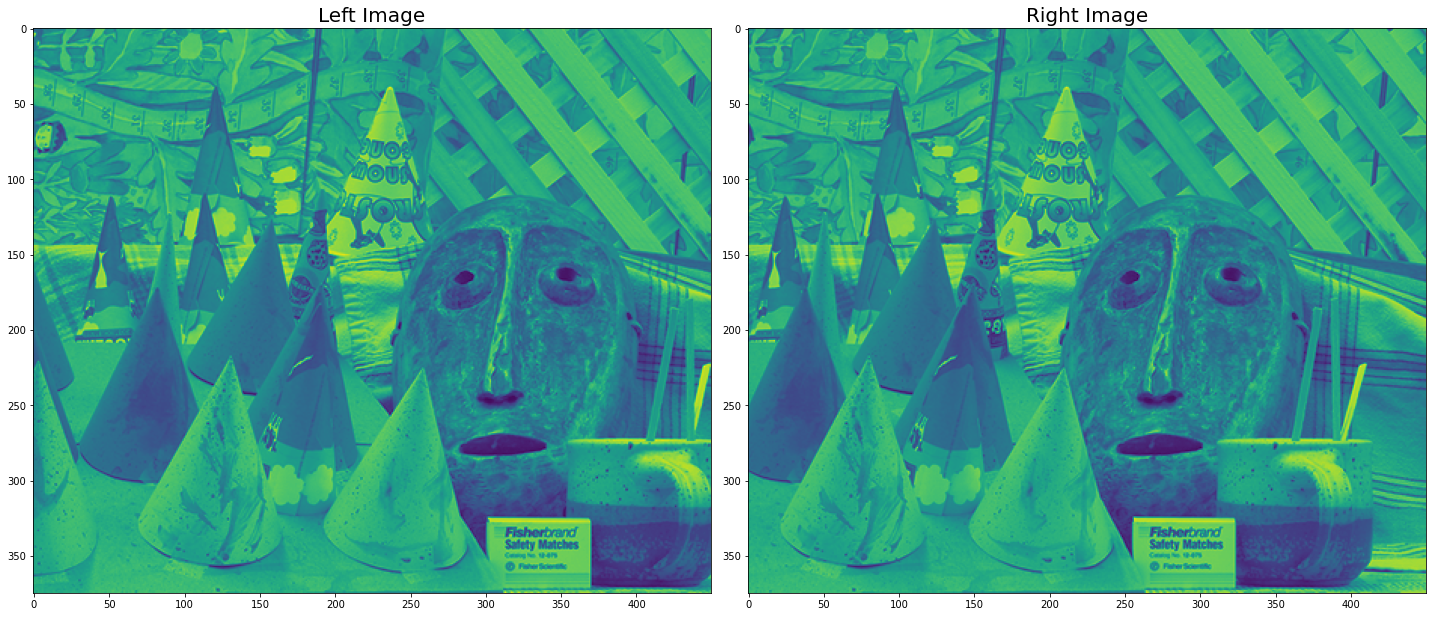

In [3]:
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(image_L)
plt.title('Left Image', fontsize=20)
plt.subplot(122)
plt.imshow(image_R)
plt.title('Right Image', fontsize=20)
plt.tight_layout()

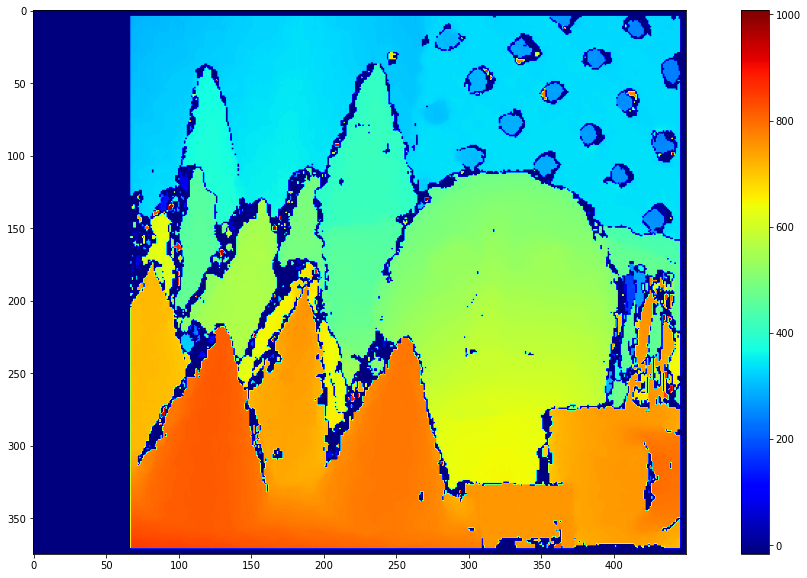

In [4]:
start = time.time()
stereo = cv.StereoBM_create(numDisparities=64, blockSize=9)
disparity = stereo.compute(image_L, image_R)
end = time.time()

plt.figure(figsize=(20, 10))
plt.imshow(disparity, cmap='jet')
plt.colorbar()

In [5]:
print(f'{1000*(end -start)} ms')

7.972478866577148 ms


# Real-Time Implementation


In [6]:
import PIL
import matplotlib.pyplot as plt
import cv2 as cv
import time
import numpy as np
from scipy import ndimage as nd

In [7]:
image_L = cv.imread('../Images/left_piano.png', 1)
image_L = cv.cvtColor(image_L, cv.COLOR_BGR2RGB)
image_R = cv.imread('../Images/right_piano.png', 1)
image_R = cv.cvtColor(image_R, cv.COLOR_BGR2RGB)

image_L_gray = cv.cvtColor(image_L, cv.COLOR_BGR2GRAY) + 1e-1
image_R_gray = cv.cvtColor(image_R, cv.COLOR_BGR2GRAY) + 1e-1

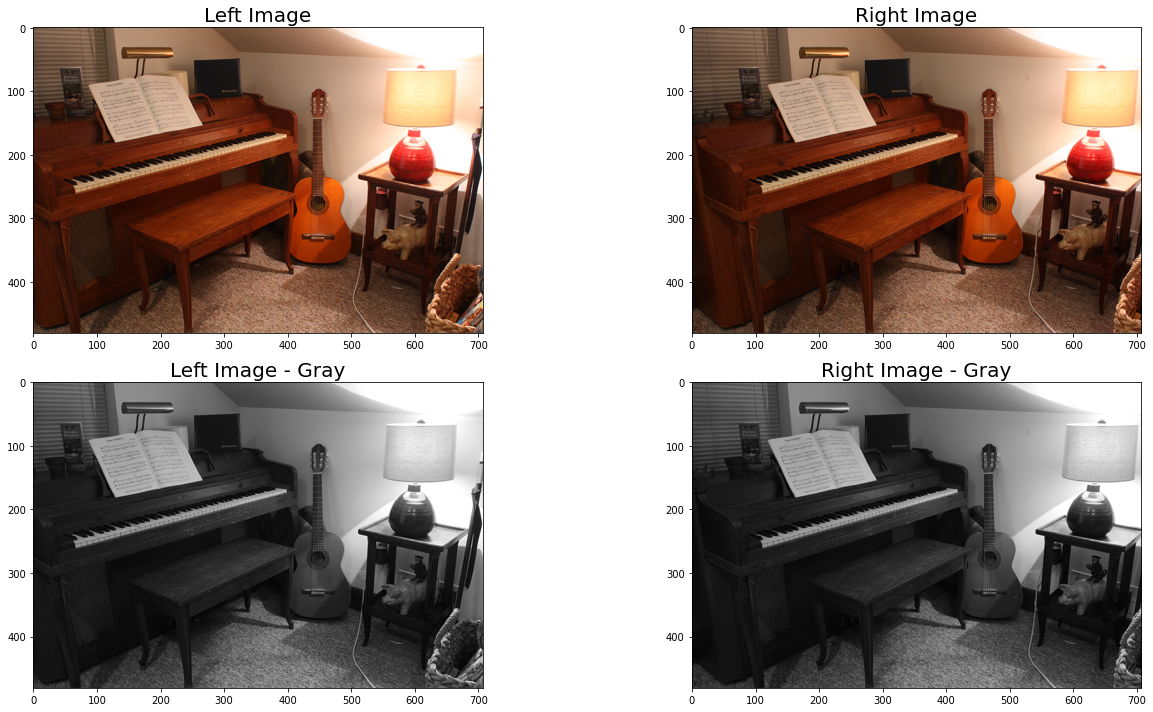

In [8]:
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.imshow(image_L)
plt.title('Left Image', fontsize=20)
plt.subplot(222)
plt.imshow(image_R)
plt.title('Right Image', fontsize=20)
plt.subplot(223)
plt.imshow(image_L_gray, cmap='gray')
plt.title('Left Image - Gray', fontsize=20)
plt.subplot(224)
plt.imshow(image_R_gray, cmap='gray')
plt.title('Right Image - Gray', fontsize=20)
plt.tight_layout()

In [9]:
def cost_block_matching(image_L_gray, image_R_gray, block_x, block_y, disp):

    column_offset = np.floor(block_x/2).astype(int)
    row_offset = np.floor(block_y/2).astype(int)

    col_bound_L = column_offset + disp
    col_bound_U = image_L_gray.shape[1] - column_offset
    row_bound_L = row_offset
    row_bound_U = image_L_gray.shape[0] - row_offset

    cost = np.empty((row_bound_U-row_bound_L, col_bound_U-col_bound_L, disp))

    L_avg = nd.uniform_filter(image_L_gray, (block_y, block_x), mode='constant')
    R_avg = nd.uniform_filter(image_R_gray, (block_y, block_x), mode='constant')

    for d in range(0, disp):
        for r in range(row_bound_L, row_bound_U):
            for c in range(col_bound_L, col_bound_U):

                L_cost = (image_L_gray[r-row_offset:r+row_offset+1, c-column_offset:c+column_offset+1] - L_avg[r, c])
                R_cost = (image_R_gray[r-row_offset:r+row_offset+1, c-column_offset-d:c+column_offset-d+1] - R_avg[r, c-d])

                cost[r-row_bound_L, c-col_bound_L, d] = np.sum(L_cost*R_cost)/np.sqrt((np.sum(L_cost**2)*np.sum(R_cost**2)))

    return cost, row_bound_U-row_bound_L, col_bound_U-col_bound_L

def multiblock(image_L, image_R, block1_x, block1_y, block2_x, block2_y, block3_x, block3_y, disp):

    triblock = np.zeros(np.append(image_L_gray.shape, 3))

    block1, row_size_1, col_size_1 = cost_block_matching(image_L_gray, image_R_gray, block1_x, block1_y, disp)
    block2, row_size_2, col_size_2 = cost_block_matching(image_L_gray, image_R_gray, block2_x, block2_y, disp)
    block3, row_size_3, col_size_3 = cost_block_matching(image_L_gray, image_R_gray, block3_x, block3_y, disp)

    R1 = (image_L_gray.shape[0] - row_size_1 - np.floor(block1_y/2))
    R2 = (image_L_gray.shape[0] - row_size_2 - np.floor(block2_y/2))
    R3 = (image_L_gray.shape[0] - row_size_3 - np.floor(block3_y/2))
    R1 = int(R1)
    R2 = int(R2)
    R3 = int(R3)

    C1 = (image_L_gray.shape[1] - col_size_1 - np.floor(block1_x/2) - 8)
    C2 = (image_L_gray.shape[1] - col_size_2 - np.floor(block2_x/2) - 8)
    C3 = (image_L_gray.shape[1] - col_size_3 - np.floor(block3_x/2) - 8)
    C1 = int(C1)
    C2 = int(C2)
    C3 = int(C3)

    triblock[R1:-R1, C1:-C1, 0] = block1[:, :, 0]
    triblock[R2:-R2, C2:-C2, 1] = block2[:, :, 0]
    triblock[R3:-R3, C3:-C3, 2] = block3[:, :, 0]

    triblock = np.prod(triblock, 2)

    return triblock



In [10]:
start = time.time()
mblock = multiblock(image_L_gray, image_R_gray, 9, 9, 21, 3, 3, 21, 16)
end = time.time()
print(f'{end - start} seconds')

C:\Users\TIMOTH~1\AppData\Local\Temp/ipykernel_4812/310468254.py:23: RuntimeWarning: invalid value encountered in double_scalars
  cost[r-row_bound_L, c-col_bound_L, d] = np.sum(L_cost*R_cost)/np.sqrt((np.sum(L_cost**2)*np.sum(R_cost**2)))


319.41346549987793 seconds


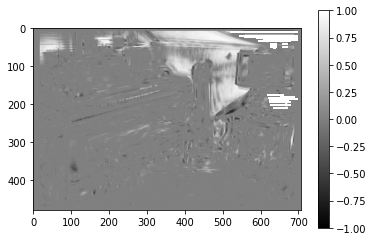

In [11]:
plt.imshow(mblock, cmap='gray')
plt.colorbar()

In [12]:
start = time.time()
B, _, _ = cost_block_matching(image_L_gray, image_R_gray, 9, 9, 16)
end = time.time()
print(f'{end - start} seconds')

109.11537432670593 seconds


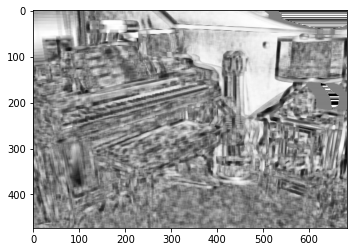

In [13]:
plt.imshow(B[:, :, 0], cmap='gray')

In [28]:
block_x = 9
block_y = 9
disp = 16

column_offset = np.floor(block_x/2).astype(int)
row_offset = np.floor(block_y/2).astype(int)

col_bound_L = column_offset + disp
col_bound_U = image_L_gray.shape[1] - column_offset
row_bound_L = row_offset
row_bound_U = image_L_gray.shape[0] - row_offset
rsize= row_bound_U - row_bound_L

cost = np.empty((row_bound_U-row_bound_L, col_bound_U-col_bound_L, disp))
cost_vec = cost

L_avg = nd.uniform_filter(image_L_gray, (block_y, block_x), mode='constant')
R_avg = nd.uniform_filter(image_R_gray, (block_y, block_x), mode='constant')

In [15]:
start = time.time()
for d in range(0, disp):
    for r in range(row_bound_L, row_bound_U):
        for c in range(col_bound_L, col_bound_U):

            L_cost = (image_L_gray[r-row_offset:r+row_offset+1, c-column_offset:c+column_offset+1] - L_avg[r, c])
            R_cost = (image_R_gray[r-row_offset:r+row_offset+1, c-column_offset-d:c+column_offset-d+1] - R_avg[r, c-d])

            cost[r-row_bound_L, c-col_bound_L, d] = np.sum(L_cost*R_cost)/np.sqrt((np.sum(L_cost**2)*np.sum(R_cost**2)))
end = time.time()
print(f'{end - start} seconds')

111.21912622451782 seconds


In [16]:
r = row_bound_L
c = col_bound_L
(image_L_gray[r-row_offset:r+row_offset+1, c-column_offset:c+column_offset+1] - L_avg[r, c]).sum()

-1.7905676941154525e-12

In [17]:
(image_L_gray - L_avg)[]

SyntaxError: invalid syntax (Temp/ipykernel_4812/2676236956.py, line 1)

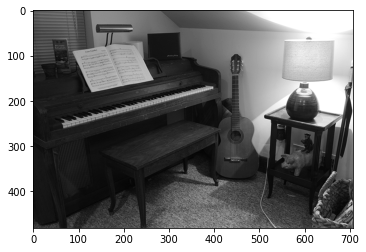

In [18]:
plt.imshow(image_L_gray, cmap='gray')

In [19]:
idx, idx.flatten().reshape(idx.shape)

NameError: name 'idx' is not defined

In [20]:
image_L_gray[row_bound_L+60, col_bound_L+17], image_L_gray.flatten()[(707)*(row_bound_L+60) + col_bound_L+17]

(87.1, 87.1)

In [21]:
image_L_gray, image_L_gray.flatten()

(array([[102.1, 102.1, 103.1, ..., 255.1, 255.1, 255.1],
        [ 86.1,  87.1,  87.1, ..., 255.1, 255.1, 255.1],
        [ 80.1,  79.1,  78.1, ..., 255.1, 255.1, 255.1],
        ...,
        [ 63.1,  71.1,  61.1, ..., 113.1,  82.1,  92.1],
        [ 56.1,  41.1,  66.1, ...,  94.1, 111.1,  85.1],
        [ 47.1,  47.1,  67.1, ...,  65.1,  92.1, 106.1]]),
 array([102.1, 102.1, 103.1, ...,  65.1,  92.1, 106.1]))

In [22]:
A = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16]])
B = np.array([[3, 3, 3, 3], [1, 1, 1, 1], [2, 2, 2, 2], [4, 4, 4, 4]])
A, A.flatten()

(array([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12],
        [13, 14, 15, 16]]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]))

In [23]:
A.flatten()[4*(3-1) + 3 - 1]

11

In [24]:
image_L_gray[1, 0], image_L_gray.flatten()[rsize-10]

(86.1, 169.1)

In [25]:
np.argwhere(image_L_gray.flatten() == image_L_gray[row_bound_L, col_bound_L])

array([[   122],
       [   351],
       [   353],
       ...,
       [339987],
       [339994],
       [339997]], dtype=int64)

In [26]:
plt.imshow(image_L_gray.flatten()[idx.flatten()].reshape(idx.shape), cmap='gray')

NameError: name 'idx' is not defined

In [29]:
start = time.time()
for d in range(0, disp):
  idx = (np.arange(row_bound_L, row_bound_U)*rsize + \
        np.arange(col_bound_L, col_bound_U).reshape(-1, 1)).transpose()
  bead = (np.arange(-row_offset, row_offset+1)*rsize + \
          np.arange(-column_offset, column_offset+1).reshape(-1, 1)).reshape(-1, 1)

  L_string = idx.flatten()
  R_string = (idx - d).flatten()
  L_braid  = L_string + bead
  R_braid  = L_string + bead

  L_cost_str = (image_L_gray - \
                L_avg).flatten()[L_braid.flatten()].reshape(L_braid.shape)
  R_cost_str = (image_R_gray - \
                R_avg).flatten()[R_braid.flatten()].reshape(R_braid.shape)
  LR_cost_str = L_cost_str*R_cost_str

  L_cost = L_cost_str.sum(axis=0).reshape(idx.shape)
  R_cost = R_cost_str.sum(axis=0).reshape(idx.shape)
  L_sqr_cost = (L_cost_str**2).sum(axis=0).reshape(idx.shape)
  R_sqr_cost = (R_cost_str**2).sum(axis=0).reshape(idx.shape)
  LR_cost = LR_cost_str.sum(axis=0).reshape(idx.shape)

  cost_vec[:, :, d] = LR_cost/np.sqrt(L_sqr_cost*R_sqr_cost)
end = time.time() 
print(f'{end - start} seconds')

7.92405891418457 seconds


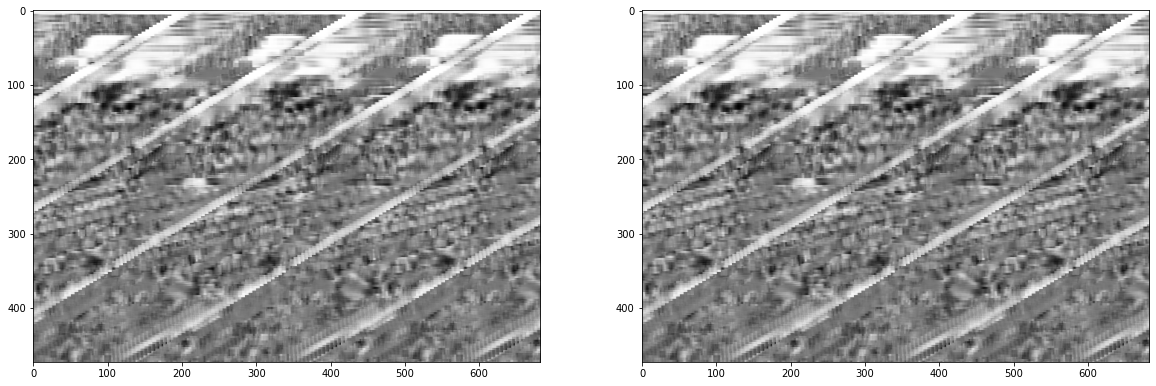

In [30]:
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(cost[:, :, 15], cmap='gray')
plt.subplot(122)
plt.imshow(cost_vec[:, :, 15], cmap='gray')

In [31]:
rsize = row_bound_U-row_bound_L
d = 10

In [42]:
rsize = row_bound_U-row_bound_L

L_img_idx = (np.arange(row_bound_L, row_bound_U)*rsize + np.arange(col_bound_L, col_bound_U).reshape(-1, 1)).transpose()
L_string = L_img_idx.flatten()
L_bead = np.arange(-row_offset, row_offset+1)*rsize + np.arange(-column_offset, column_offset+1).reshape(-1, 1) 
L_braid = (L_string + L_bead.reshape(-1, 1))
L_cost_string = image_L_gray.flatten()[img_braid.flatten()].reshape(img_braid.shape).sum(axis=0)
L_cost = L_cost_string.reshape(L_img_idx.shape)

In [43]:
L_braid.shape

(81, 323059)

In [44]:
L_string.shape, L_bead.shape

((323059,), (9, 9))

In [45]:
L_img_idx, flat_L_img.reshape(L_img_idx.shape)

NameError: name 'flat_L_img' is not defined

In [46]:
image_L_gray[row_bound_L:row_bound_U, col_bound_L:col_bound_U]

array([[ 90.1,  90.1,  89.1, ..., 255.1, 255.1, 255.1],
       [ 95.1,  95.1,  94.1, ..., 255.1, 255.1, 255.1],
       [102.1, 103.1, 102.1, ..., 255.1, 255.1, 255.1],
       ...,
       [ 27.1,  29.1,  19.1, ..., 107.1, 109.1, 108.1],
       [ 20.1,  34.1,  33.1, ...,  96.1,  83.1,  97.1],
       [ 18.1,  21.1,  30.1, ...,  79.1,  71.1,  83.1]])

In [47]:
img_string = (np.arange(row_bound_L, row_bound_U)*(row_bound_U-row_bound_L) + np.arange(col_bound_L, col_bound_U).reshape(-1, 1)).flatten()

In [48]:
img_bead = np.arange(-row_offset, row_offset+1)*(row_bound_U-row_bound_L) + np.arange(-column_offset, column_offset+1).reshape(-1, 1) 

In [49]:
img_string, img_bead

(array([  1912,   2385,   2858, ..., 224904, 225377, 225850]),
 array([[-1896, -1423,  -950,  -477,    -4,   469,   942,  1415,  1888],
        [-1895, -1422,  -949,  -476,    -3,   470,   943,  1416,  1889],
        [-1894, -1421,  -948,  -475,    -2,   471,   944,  1417,  1890],
        [-1893, -1420,  -947,  -474,    -1,   472,   945,  1418,  1891],
        [-1892, -1419,  -946,  -473,     0,   473,   946,  1419,  1892],
        [-1891, -1418,  -945,  -472,     1,   474,   947,  1420,  1893],
        [-1890, -1417,  -944,  -471,     2,   475,   948,  1421,  1894],
        [-1889, -1416,  -943,  -470,     3,   476,   949,  1422,  1895],
        [-1888, -1415,  -942,  -469,     4,   477,   950,  1423,  1896]]))

In [50]:
img_braid = (img_string + img_bead.reshape(-1, 1))
img_braid

array([[    16,    489,    962, ..., 223008, 223481, 223954],
       [   489,    962,   1435, ..., 223481, 223954, 224427],
       [   962,   1435,   1908, ..., 223954, 224427, 224900],
       ...,
       [  2862,   3335,   3808, ..., 225854, 226327, 226800],
       [  3335,   3808,   4281, ..., 226327, 226800, 227273],
       [  3808,   4281,   4754, ..., 226800, 227273, 227746]])

In [51]:
image_L_gray.flatten()[img_braid.flatten()].reshape(img_braid.shape).sum(axis=0).shape

(323059,)

In [52]:
y1 = 2
y2 = 3
z1 = 2
z2 = 3

np.arange(0, 16).reshape((4, 4)).flatten()[np.arange(z1-1, z2)*4 + np.arange(y1-1, y2).reshape(-1, 1)]

array([[ 5,  9],
       [ 6, 10]])

In [ ]:
np.arange(0, 16).reshape((4, 4))[2+]